# MKC: Web article
https://towardsdatascience.com/using-cnns-and-rnns-for-music-genre-recognition-2435fb2ed6af

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [1]:
import os

data_dir       = 'data4'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")

In [2]:
import numpy as np
import os
from os.path import isfile
import pathlib
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop, Adadelta
from keras.layers import Bidirectional

from keras import regularizers
import time

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning:

### Load training and Validation arrays

In [3]:
dict_reciter_to_label =  {'AbdurrahmaanAs-Sudais': 0, 'Ajami': 1, 'Alafasy': 2, 'FaresAbbad': 3, 'Ghamadi': 4}

dict_reciters = dict_reciter_to_label

reverse_map = {v: k for k, v in dict_reciters.items()}
print(reverse_map)

{0: 'AbdurrahmaanAs-Sudais', 1: 'Ajami', 2: 'Alafasy', 3: 'FaresAbbad', 4: 'Ghamadi'}


In [4]:
npzfile = np.load(os.path.join(data_dir, 'shuffled_train_log.npz'))
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(9000, 130, 128) (9000, 5)


In [5]:
npzfile = np.load(os.path.join(data_dir, 'shuffled_valid_log.npz'))
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(3000, 130, 128) (3000, 5)


In [6]:
# MKC: TO understand why y_valiad & y_train are not coming out as (*, 8)
import pandas as pd
y_valid_pd = pd.DataFrame(y_valid)
y_valid_pd.describe()
y_valid_pd.head()


,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


### Check by plotting a Spectogram

Alafasy


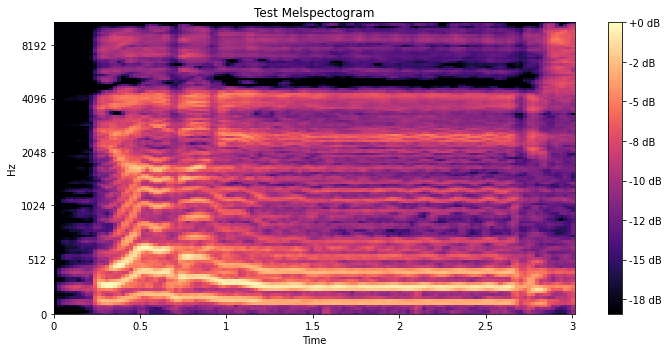

In [7]:
num = 4
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### BiLSTM Model

In [8]:
num_classes = len(dict_reciters)
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [9]:
# MKC: Convert to BiLSTM model
from keras.layers import Bidirectional
#from keras.layers import RecurrentDropout
N_LAYERS = 3
N_LAYERS = 1 # Rev12
N_LAYERS = 0 # Rev12

FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 128
LSTM_COUNT = 96
#MKC
#LSTM_COUNT_2 = LSTM_COUNT / 2
LSTM_COUNT_2 = 48

print("LSTM_COUNT_2 = ", LSTM_COUNT_2)
EPOCH_COUNT = 70
EPOCH_COUNT = 200
print("EPOCH_COUNT = ", EPOCH_COUNT)
NUM_HIDDEN = 64
L2_regularization = 0.001
print("BATCH_SIZE = ", BATCH_SIZE)


def conv_recurrent_model_build(model_input):

    input_shape = (None, n_features)
    model = Sequential()
    #model.add(Input(input_shape, name='input'))
    #model.add(Dense(64, activation='tanh', input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh'), input_shape=input_shape))
    #model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    #model.add(Dense(64, activation='sigmoid'))
    #model.add(Dropout(rate=0.30))
    model.add(Bidirectional(LSTM(32, return_sequences=True, activation='tanh')))
    #model.add(Dense(32, activation='sigmoid'))
    #model.add(Dropout(rate=0.20))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(rate=0.05))
    model.add(Dense(num_classes, activation='softmax'))

    opt = Adadelta(lr=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )
    
    print(model.summary())
    return model

LSTM_COUNT_2 =  48
EPOCH_COUNT =  200
BATCH_SIZE =  128


In [10]:
import pathlib

my_models_dir = os.path.join(os.getcwd(), "models")
if not pathlib.Path(my_models_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=my_models_dir)

my_models_dir = os.path.join(os.getcwd(), "models/bilstm")
if not pathlib.Path(my_models_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=my_models_dir)
    
def train_model(x_train, y_train, x_val, y_val, notrain=False):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    #input_shape = (X_train.shape[1], X_train.shape[2])
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/bilstmdata4/weights.best.{epoch:02d}-{val_accuracy:.2f}.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')

    # MKC: Original line was:
    #           monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
    # Changed val_acc to val_accuracy to get rid of this warning:
    3#C:\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
    #'skipping.' % (self.monitor), RuntimeWarning)
    #C:\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
    #(self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    if notrain is True:
        print("No training this time!")
        return None, None
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [11]:
print("Compiling ...")
junk1, junk2  = train_model(X_train, y_train, X_valid, y_valid, notrain=True)

Compiling ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 152,613
Trainable params: 152,613
Non-trainable params: 0
_________________________________________________________________
None
No training this time!


In [12]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    # MKC: Changed acc to accuracy
    #plt.plot(history.history['acc'])
    plt.plot(history.history['accuracy'])
    # MKC: Changed val_acc to val_accuracy
    #plt.plot(history.history['val_acc'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
t0 = time.time()

model, history  = train_model(X_train, y_train, X_valid, y_valid)

print("DONE in {:0.3} sec\n".format(time.time() - t0))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 152,613
Trainable params: 152,613
Non-trainable params: 0
_________________________________________________________________
None
Training...
Train on 9000 samples, validate on 3000 samples
Epoch 1/200
9000/9000 [==========================

9000/9000 [==============================] - 103s 11ms/step - loss: 1.2979 - accuracy: 0.7213 - val_loss: 1.2861 - val_accuracy: 0.7397

Epoch 00027: val_accuracy improved from 0.73633 to 0.73967, saving model to ./models/bilstmdata4/weights.best.27-0.74.h5
Epoch 28/200
9000/9000 [==============================] - 103s 11ms/step - loss: 1.2861 - accuracy: 0.7250 - val_loss: 1.2730 - val_accuracy: 0.7437

Epoch 00028: val_accuracy improved from 0.73967 to 0.74367, saving model to ./models/bilstmdata4/weights.best.28-0.74.h5
Epoch 29/200
9000/9000 [==============================] - 102s 11ms/step - loss: 1.2730 - accuracy: 0.7372 - val_loss: 1.2600 - val_accuracy: 0.7490

Epoch 00029: val_accuracy improved from 0.74367 to 0.74900, saving model to ./models/bilstmdata4/weights.best.29-0.75.h5
Epoch 30/200
9000/9000 [==============================] - 102s 11ms/step - loss: 1.2606 - accuracy: 0.7341 - val_loss: 1.2470 - val_accuracy: 0.7517

Epoch 00030: val_accuracy improved from 0.74900 to

9000/9000 [==============================] - 101s 11ms/step - loss: 0.9418 - accuracy: 0.8418 - val_loss: 0.9205 - val_accuracy: 0.8517

Epoch 00057: val_accuracy improved from 0.84833 to 0.85167, saving model to ./models/bilstmdata4/weights.best.57-0.85.h5
Epoch 58/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.9305 - accuracy: 0.8440 - val_loss: 0.9094 - val_accuracy: 0.8540

Epoch 00058: val_accuracy improved from 0.85167 to 0.85400, saving model to ./models/bilstmdata4/weights.best.58-0.85.h5
Epoch 59/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.9187 - accuracy: 0.8470 - val_loss: 0.8984 - val_accuracy: 0.8580

Epoch 00059: val_accuracy improved from 0.85400 to 0.85800, saving model to ./models/bilstmdata4/weights.best.59-0.86.h5
Epoch 60/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.9083 - accuracy: 0.8526 - val_loss: 0.8875 - val_accuracy: 0.8597

Epoch 00060: val_accuracy improved from 0.85800 to


Epoch 00087: val_accuracy improved from 0.91700 to 0.91867, saving model to ./models/bilstmdata4/weights.best.87-0.92.h5
Epoch 88/200
9000/9000 [==============================] - 103s 11ms/step - loss: 0.6365 - accuracy: 0.9176 - val_loss: 0.6183 - val_accuracy: 0.9197

Epoch 00088: val_accuracy improved from 0.91867 to 0.91967, saving model to ./models/bilstmdata4/weights.best.88-0.92.h5
Epoch 89/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.6293 - accuracy: 0.9190 - val_loss: 0.6101 - val_accuracy: 0.9203

Epoch 00089: val_accuracy improved from 0.91967 to 0.92033, saving model to ./models/bilstmdata4/weights.best.89-0.92.h5
Epoch 90/200
9000/9000 [==============================] - 101s 11ms/step - loss: 0.6211 - accuracy: 0.9193 - val_loss: 0.6022 - val_accuracy: 0.9217

Epoch 00090: val_accuracy improved from 0.92033 to 0.92167, saving model to ./models/bilstmdata4/weights.best.90-0.92.h5
Epoch 91/200
9000/9000 [==============================] - 101s 11

9000/9000 [==============================] - 101s 11ms/step - loss: 0.5234 - accuracy: 0.9352 - val_loss: 0.5081 - val_accuracy: 0.9353

Epoch 00119: val_accuracy improved from 0.93500 to 0.93533, saving model to ./models/bilstmdata4/weights.best.119-0.94.h5
Epoch 120/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.5229 - accuracy: 0.9332 - val_loss: 0.5073 - val_accuracy: 0.9353

Epoch 00120: val_accuracy did not improve from 0.93533
Epoch 121/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.5215 - accuracy: 0.9359 - val_loss: 0.5066 - val_accuracy: 0.9353

Epoch 00121: val_accuracy did not improve from 0.93533
Epoch 122/200
9000/9000 [==============================] - 101s 11ms/step - loss: 0.5205 - accuracy: 0.9339 - val_loss: 0.5059 - val_accuracy: 0.9353

Epoch 00122: val_accuracy did not improve from 0.93533
Epoch 123/200
9000/9000 [==============================] - 101s 11ms/step - loss: 0.5191 - accuracy: 0.9353 - val_loss: 0.5

9000/9000 [==============================] - 101s 11ms/step - loss: 0.5096 - accuracy: 0.9372 - val_loss: 0.4966 - val_accuracy: 0.9353

Epoch 00157: val_accuracy did not improve from 0.93567

Epoch 00157: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 158/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.5105 - accuracy: 0.9354 - val_loss: 0.4965 - val_accuracy: 0.9353

Epoch 00158: val_accuracy did not improve from 0.93567
Epoch 159/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.5111 - accuracy: 0.9370 - val_loss: 0.4965 - val_accuracy: 0.9353

Epoch 00159: val_accuracy did not improve from 0.93567
Epoch 160/200
9000/9000 [==============================] - 101s 11ms/step - loss: 0.5104 - accuracy: 0.9360 - val_loss: 0.4965 - val_accuracy: 0.9353

Epoch 00160: val_accuracy did not improve from 0.93567
Epoch 161/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.5103 - accuracy: 0.9352 -

9000/9000 [==============================] - 102s 11ms/step - loss: 0.5094 - accuracy: 0.9386 - val_loss: 0.4959 - val_accuracy: 0.9357

Epoch 00195: val_accuracy did not improve from 0.93567
Epoch 196/200
9000/9000 [==============================] - 101s 11ms/step - loss: 0.5099 - accuracy: 0.9382 - val_loss: 0.4959 - val_accuracy: 0.9357

Epoch 00196: val_accuracy did not improve from 0.93567
Epoch 197/200
9000/9000 [==============================] - 102s 11ms/step - loss: 0.5099 - accuracy: 0.9357 - val_loss: 0.4959 - val_accuracy: 0.9357

Epoch 00197: val_accuracy did not improve from 0.93567

Epoch 00197: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 198/200
9000/9000 [==============================] - 101s 11ms/step - loss: 0.5090 - accuracy: 0.9376 - val_loss: 0.4959 - val_accuracy: 0.9357

Epoch 00198: val_accuracy did not improve from 0.93567
Epoch 199/200
9000/9000 [==============================] - 103s 11ms/step - loss: 0.5106 - accuracy: 0.9362 -

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


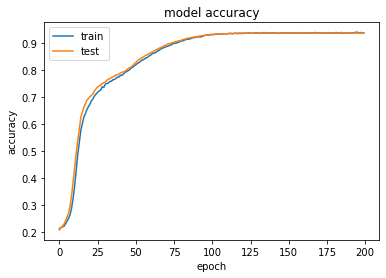

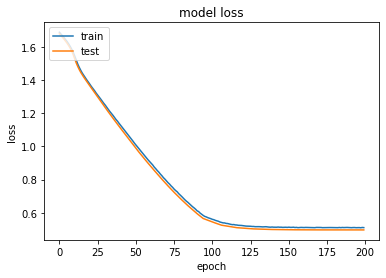

In [14]:
show_summary_stats(history)

In [15]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [i for i in range(0, len(dict_reciters))]
target_names = dict_reciters.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(3000,) (3000,)
                       precision    recall  f1-score   support

AbdurrahmaanAs-Sudais       0.97      0.91      0.94       600
                Ajami       0.89      0.99      0.94       600
              Alafasy       0.96      0.84      0.89       600
           FaresAbbad       0.95      0.95      0.95       600
              Ghamadi       0.93      0.99      0.96       600

             accuracy                           0.94      3000
            macro avg       0.94      0.94      0.93      3000
         weighted avg       0.94      0.94      0.93      3000



In [16]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.9356666666666666


### Connect to Test Set

In [17]:
from keras.models import load_model

#weights_path = 'models/bilstm/weights.best.h5'
#weights_path = './models/bilstm/weights.best.06-0.89.h5'
weights_path = './models/bilstmdata4/weights.best.142-0.94.h5'
model = load_model(weights_path)

In [18]:
npzfile = np.load(os.path.join(data_dir, 'test_arr.npz'))
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(3000, 130, 128) (3000, 5)


In [19]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

-1.0 0.0 -0.8


In [20]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000008783668917 0.005049899452005801


In [21]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [i for i in range(0, len(dict_reciters))]
target_names = dict_reciters.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(3000,) (3000,)
                       precision    recall  f1-score   support

AbdurrahmaanAs-Sudais       0.21      0.20      0.21       600
                Ajami       0.20      0.22      0.21       600
              Alafasy       0.20      0.17      0.18       600
           FaresAbbad       0.19      0.19      0.19       600
              Ghamadi       0.21      0.22      0.21       600

             accuracy                           0.20      3000
            macro avg       0.20      0.20      0.20      3000
         weighted avg       0.20      0.20      0.20      3000



In [22]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[121 130  91 124 134]
 [116 131  99 132 122]
 [127 133 102 121 117]
 [113 127 108 112 140]
 [ 98 143 109 116 134]]


In [23]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.2


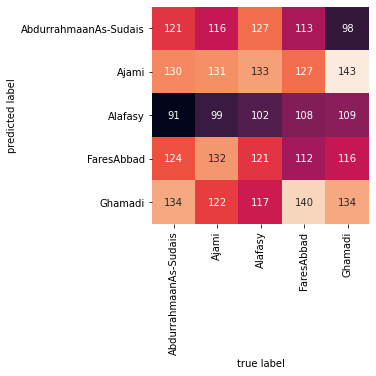

In [24]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_reciters.keys(),
            yticklabels=dict_reciters.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
